# 灰度转换

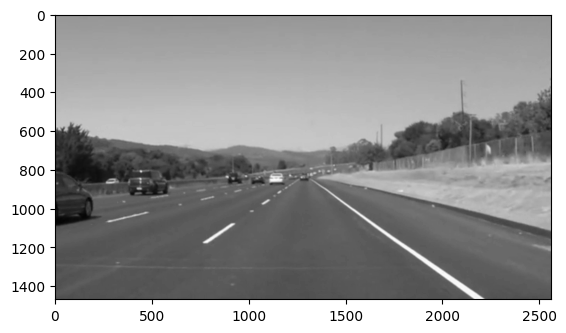

In [107]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
 
img = Image.open('./test_img.jpg')# 读取图像
grey_img = np.array(img.convert('L'), dtype=np.int32)# 转为灰度图，再转为numpy数组

plt.imshow(grey_img, cmap='gray')#彩色图转灰度图
plt.show()

# 高斯滤波

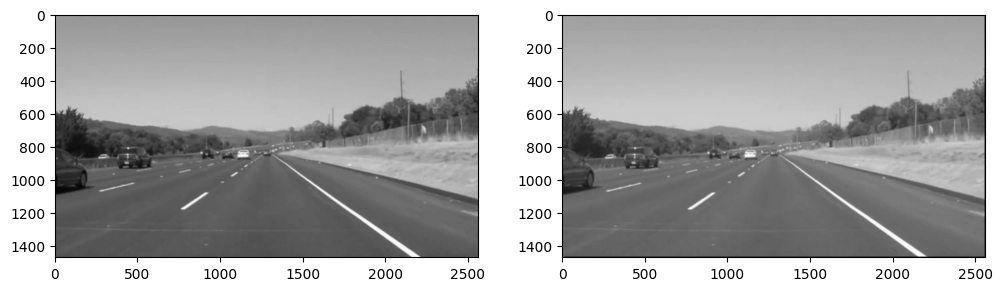

float64
float64


In [108]:
def gaussian_filter(sigma, size):
    middle = (size + 1)/2
    gaussian_function = lambda x,y : (1/(2*np.pi*sigma**2)) * np.exp(-((x**2 + y**2)/(2*sigma**2)))
    gau_filter = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            gau_filter[i][j] = gaussian_function(i-middle+1, j-middle+1)
    return gau_filter / np.sum(gau_filter)

def conv2d(input, kernel, bias=0, stride=1, padding=0):
    # input可以是图像经数组化的二维矩阵，kernel为卷积核本身输入，函数应可计算图像尺寸，改写卷积核，偏置，步长和填充。
    
    # 输入图像和卷积核的维度
    input_height, input_width = input.shape
    kernel_height, kernel_width = kernel.shape

    # 计算输出图像的尺寸
    output_height = int(((input_height - kernel_height + 2 * padding) / stride) + 1)
    output_width = int(((input_width - kernel_width + 2 * padding) / stride) + 1)

    # 创建一个用于存储卷积结果的数组
    output = np.zeros((output_height, output_width))

    # 应用填充
    if padding > 0:
        input = np.pad(input, padding, mode='constant') # 填充常数，默认为0

    # 进行卷积操作
    for i in range(0, input_height - kernel_height + 1, stride):
        for j in range(0, input_width - kernel_width + 1, stride):
            output[i, j] = np.sum(input[i:i+kernel_height, j:j+kernel_width] * kernel) + bias

    return output

def filter(img, kernel):
    process_img = conv2d(img, kernel, 0, 1, 1)

    min_pixel = np.min(process_img)
    max_pixel = np.max(process_img)
    stretched_image = ((process_img - min_pixel) / (max_pixel - min_pixel)) * 255
    # stretched_image = stretched_image.astype(np.uint8)  # 转换为0-255之间的整数

    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.subplot(122)
    plt.imshow(process_img, cmap='gray')#彩色图转灰度图
    plt.show()

    print(process_img.dtype)
    print(stretched_image.dtype)

    return stretched_image

gau_filter = gaussian_filter(0.8, 5)
process_img = filter(grey_img, gau_filter)

# CANNY边缘检测
1. 高斯滤波去噪
2. 计算梯度的幅度与方向
   <div align=left><img src="./images/1.jpg" width="40%" ></img></div>
3. 非极大值抑制，即适当地让边缘“变瘦”。
   1. 获得了梯度的幅度和方向后，遍历图像中的像素点，去除所有非边缘的点：逐一遍历像素点，判断当前像素点是否是周围像素点中具有相同梯度方向的最大值，并根据判断结果决定是否抑制该点
4. 确定边缘，使用双阈值算法确定边缘信息
5. 抑制孤立的弱边缘最终完成边缘检测
   1. 对于弱边缘像素，将会有一些争论，因为这些像素可以从真实边缘提取也可以是因噪声或颜色变化引起的。为了获得准确的结果，应该抑制由后者引起的弱边缘。通常，由真实边缘引起的弱边缘像素将连接到强边缘像素，而噪声响应未连接。为了跟踪边缘连接，通过查看弱边缘像素及其8个邻域像素，只要其中一个为强边缘像素，则该弱边缘点就可以保留为真实的边缘

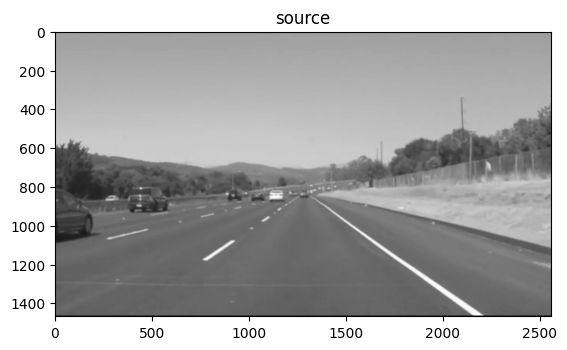

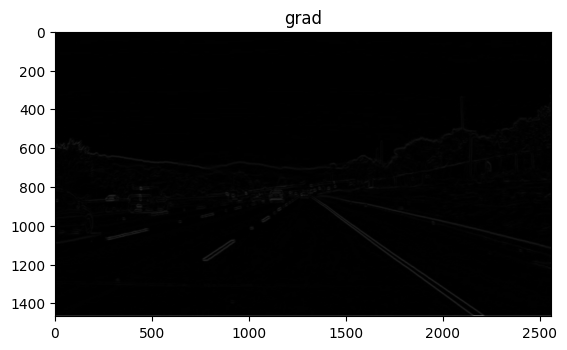

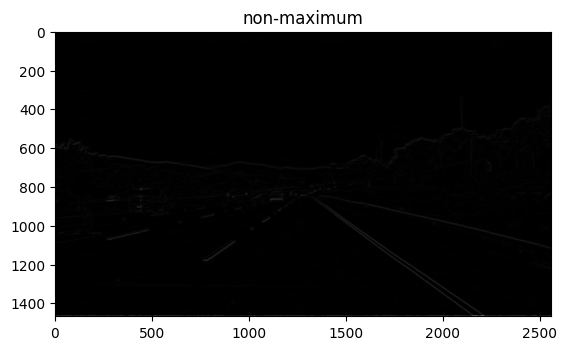

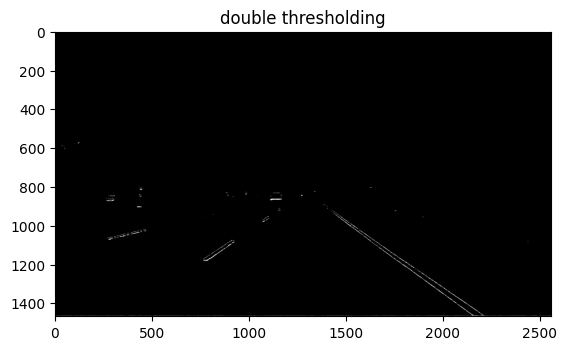

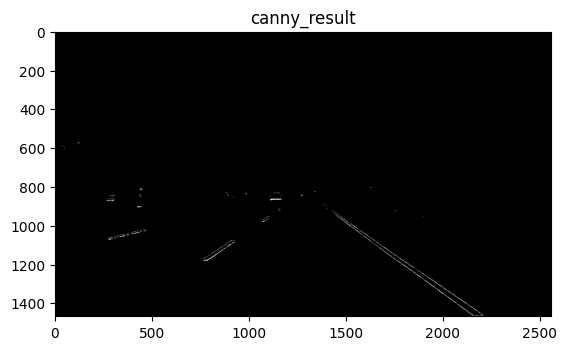

In [109]:
import numpy as np
from matplotlib import pyplot as plt
import math

# 假设 process_img 是一个 NumPy 数组
canny_img1 = np.array(process_img)

plt.figure(1)
plt.title('source')
plt.imshow(canny_img1, cmap='gray')

# 计算梯度
grad_x = np.zeros_like(canny_img1)
grad_y = np.zeros_like(canny_img1)

grad_x[1:-1, 1:-1] = canny_img1[1:-1, 2:] + canny_img1[:-2, 2:] + 2 * canny_img1[1:-1, 1:-1] - \
                    canny_img1[:-2, :-2] - canny_img1[1:-1, :-2] - 2 * canny_img1[:-2, 1:-1]

grad_y[1:-1, 1:-1] = canny_img1[2:, :-2] + canny_img1[2:, 2:] + 2 * canny_img1[2:, 1:-1] - \
                    canny_img1[:-2, :-2] - canny_img1[:-2, 2:] - 2 * canny_img1[:-2, 1:-1]

grad_x = np.floor(grad_x / 4)
grad_y = np.floor(grad_y / 4)

grad_mag = np.floor(np.sqrt(grad_x**2 + grad_y**2))
grad_mag[grad_mag > 255] = 255

grad_dir = np.zeros_like(grad_x)
grad_dir[grad_x == 0] = 2  # y 方向
grad_dir[grad_x != 0] = np.floor(np.arctan2(grad_y[grad_x != 0], grad_x[grad_x != 0]) / (np.pi / 8))
grad_dir[(grad_dir < 0) & (grad_dir >= -3)] += 4  # 将负角度转换为正值

# 显示梯度幅度图
plt.figure(2)
plt.title('grad')
plt.imshow(grad_mag, cmap='gray')

# 非极大值抑制
canny_img2 = grad_mag.copy()

for j in range(1, grad_mag.shape[0] - 1):
    for i in range(1, grad_mag.shape[1] - 1):
        dir = grad_dir[j, i]
        grad_now = grad_mag[j, i]

        if dir == 0 and (grad_now < grad_mag[j, i + 1] or grad_now < grad_mag[j, i - 1]):
            canny_img2[j, i] = 0
        elif dir == 1 and (grad_now < grad_mag[j + 1, i + 1] or grad_now < grad_mag[j - 1, i - 1]):
            canny_img2[j, i] = 0
        elif dir == 2 and (grad_now < grad_mag[j + 1, i] or grad_now < grad_mag[j - 1, i]):
            canny_img2[j, i] = 0
        elif dir == 3 and (grad_now < grad_mag[j + 1, i - 1] or grad_now < grad_mag[j - 1, i + 1]):
            canny_img2[j, i] = 0

# 显示非极大值抑制后的结果
plt.figure(3)
plt.title('non-maximum')
plt.imshow(canny_img2, cmap='gray')

# 双阈值检测
low = 30
high = 40

canny_img2[(canny_img2 >= low) & (canny_img2 <= high)] = 255
canny_img2[canny_img2 < low] = 0

# 显示双阈值检测后的结果
plt.figure(4)
plt.title('double thresholding')
plt.imshow(canny_img2, cmap='gray')

# 抑制孤立的弱边缘
listx, listy = np.meshgrid([-1, 0, 1], [-1, 0, 1])
canny_img3 = canny_img2.copy()

for j in range(1, canny_img2.shape[0] - 1):
    for i in range(1, canny_img2.shape[1] - 1):
        if np.all(canny_img2[j + listy, i + listx] != 255):
            canny_img3[j, i] = 0

# 显示最终结果
plt.figure(5)
plt.title('canny_result')
plt.imshow(canny_img3, cmap='gray')

plt.show()


# 提取感兴趣区域ROI
1. 生成mask（掩膜）： 一个掩膜是一个与原始图像具有相同尺寸的图像，其中的像素值通常是二进制的，用于指示图像中哪些部分是感兴趣的（被保留）和哪些是不感兴趣的（被忽略）
2. 提取感兴趣区域（ROI）： 一旦有了掩膜，提取感兴趣区域就是通过将掩膜应用于原始图像，只保留掩膜中指定的区域

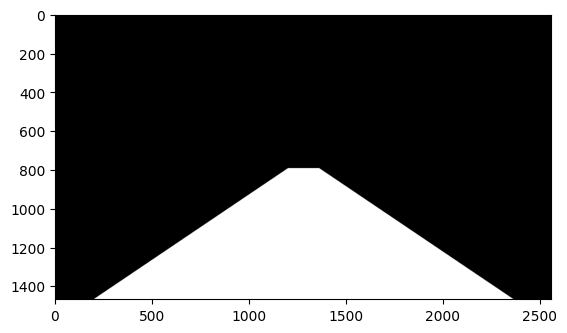

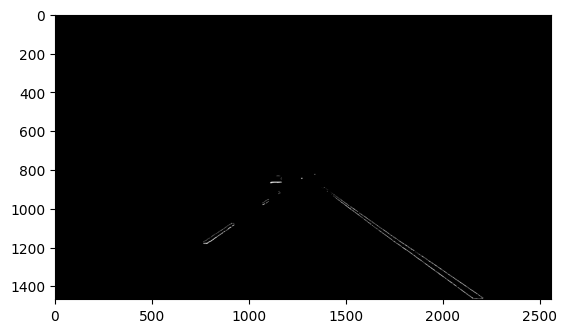

In [110]:
import cv2

# 定义ROI区域
height, width = canny_img3.shape
roi_vertices = [(200, height), (width / 2-80, height / 2+60), (width / 2+80, height / 2+60), (width-200, height)]

# 创建掩膜
mask = np.zeros_like(canny_img3)
cv2.fillPoly(mask, [np.array(roi_vertices, np.int32)], 255)

# 应用掩膜
masked_img = cv2.bitwise_and(canny_img3, mask)


# 显示原始图像和处理后的图像
mask = np.zeros((height, width), dtype=np.uint8)
cv2.fillPoly(mask, [np.array(roi_vertices, np.int32)], 255)

# 显示掩膜
plt.figure(6)
plt.imshow(mask, cmap='gray')
plt.figure(7)
plt.imshow(masked_img, cmap='gray')
plt.show()

# 霍夫变换
1. 大致原理为
   1. 笛卡尔空间中的一个点对应霍夫空间的一个直线，笛卡尔空间中的一个直线对应霍夫空间的一个点
   2. 当笛卡尔空间的n个点共线时，这n个点对应的霍夫空间的n条线也会交于一点，该点反过来对应笛卡尔空间n点共的那条线
   3. 对霍夫空间进行坐标变换，变换为极坐标，可以得到霍夫空间的线与笛卡尔空间的点的对应关系如下
      <div align=left><img src="./images/2.jpg" width="40%" ></img></div>
   4. 将笛卡尔空间下的点均转为霍夫空间的线，并按以下方式求交点，取计数次数最多的点即为图片中的线
      <div align=left><img src="./images/3.jpg" width="40%" ></img></div>
2. 详细原理见[文章](https://zhuanlan.zhihu.com/p/203292567)

(73, 1, 4)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


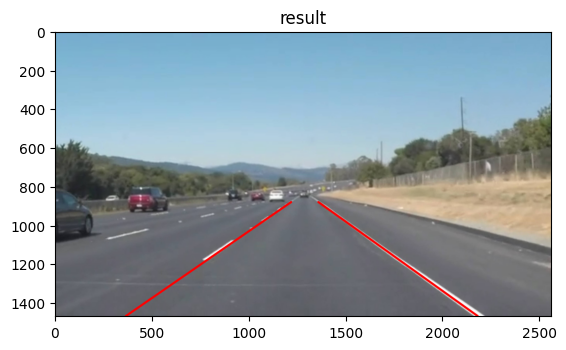

In [116]:
import cv2

def display_lines(image, lines):
    lines_image = np.zeros_like(image)
    #make sure array isn't empty
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line
            #draw lines on a black image
            cv2.line(lines_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return lines_image

def make_points(image, average):
    # print(average)
    slope, y_int = average
    y1 = image.shape[0]
    #how long we want our lines to be --> 3/5 the size of the image
    y2 = int(y1 * (3/5))
    #determine algebraically
    x1 = int((y1 - y_int) // slope)
    x2 = int((y2 - y_int) // slope)
    return np.array([x1, y1, x2, y2])

def average(image, lines):
    left = []
    right = []
    for line in lines:
        # print(line)
        x1, y1, x2, y2 = line.reshape(4)
        #fit line to points, return slope and y-int
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        # print(parameters)
        slope = parameters[0]
        y_int = parameters[1]
        #lines on the right have positive slope, and lines on the left have neg slope
        if slope < 0:
            left.append((slope, y_int))
        else:
            right.append((slope, y_int))
    #takes average among all the columns (column0: slope, column1: y_int)
    right_avg = np.average(right, axis=0)
    left_avg = np.average(left, axis=0)
    #create lines based on averages calculates
    left_line = make_points(image, left_avg)
    right_line = make_points(image, right_avg)
    return np.array([left_line, right_line])

def hough_lines(image, rho_resolution, theta_resolution, threshold): # min_line_length max_line_gap
    # 图像的高度和宽度
    height, width = image.shape[:2]

    # 极坐标参数空间的大小
    rho_max = np.sqrt(height**2 + width**2)
    rho_bins = int(2 * np.ceil(rho_max / rho_resolution)) + 1  # 向上取整并加1
    theta_bins = int(np.ceil(np.pi / theta_resolution))  # 向上取整

    # 构建累加器
    accumulator = np.zeros((rho_bins, theta_bins), dtype=np.uint8)

    # 遍历图像中的每个像素
    edges = np.argwhere(image != 0)
    for y, x in edges:
        for theta_idx in range(theta_bins):
            theta = theta_idx * theta_resolution
            rho = x * np.cos(theta) + y * np.sin(theta)
            rho_idx = int(np.round(rho / rho_resolution)) + rho_bins // 2
            accumulator[rho_idx, theta_idx] += 1

    # 根据阈值选取直线
    lines = []
    for rho_idx in range(rho_bins):
        for theta_idx in range(theta_bins):
            if accumulator[rho_idx, theta_idx] > threshold:
                rho = (rho_idx - rho_bins // 2) * rho_resolution
                theta = theta_idx * theta_resolution
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a * rho
                y0 = b * rho
                x1 = int(x0 + 1000 * (-b))
                y1 = int(y0 + 1000 * (a))
                x2 = int(x0 - 1000 * (-b))
                y2 = int(y0 - 1000 * (a))
                lines.append(np.array([[x1, y1, x2, y2]]))

    return np.array(lines)

masked_img_copy = masked_img.astype(np.uint8)
img2 = np.copy(img)

# lines = cv2.HoughLinesP(masked_img_copy, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)
# print(lines.shape)

rho_resolution = 1
theta_resolution = np.pi / 180
threshold = 100
min_line_length = 40
max_line_gap = 5
lines = hough_lines(masked_img_copy, rho_resolution, theta_resolution, threshold)
print(lines.shape)

averaged_lines = average(img2, lines)
black_lines = display_lines(img2, averaged_lines)
#taking wighted sum of original image and lane lines image

# lanes = cv2.addWeighted(img2, 0, black_lines, 1, 1)
red_mask = (black_lines[:, :, 2] == 0) & (black_lines[:, :, 0] != 0) & (black_lines[:, :, 1] == 0)
print(red_mask)
# 直接将红线部分的像素改为红色
img2[red_mask] = [255, 0, 0]  # 设置为红色


plt.figure(8)
plt.title('result')
plt.imshow(img2)

plt.show()
# cv2.imshow("lanes", lanes)

# 图片生成视频

In [126]:
import cv2
import os
import re

def images_to_video(input_folder, output_video_path, fps):
    image_files = os.listdir(input_folder)  # 获取文件夹下的所有文件名
    image_files = sorted(image_files, key=lambda x: int(re.findall(r'\d+', x)[0]))  # 按照数字的大小对文件名进行排序
    frame_size = None
    video_writer = None

    for image_file in image_files:
        if image_file.endswith('.jpg') or image_file.endswith('.png'):  # 修改为适合您的图片格式
            image_path = os.path.join(input_folder, image_file)
            frame = cv2.imread(image_path)  # 读取图片

            if frame_size is None:
                frame_size = (frame.shape[1], frame.shape[0])  # 获取第一张图片的尺寸

            if video_writer is None:
                fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 可根据需要更改编码器
                video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, frame_size)

            video_writer.write(frame)  # 将帧写入视频

    if video_writer is not None:
        video_writer.release()  # 释放视频写入器

# 示例用法
input_folder = 'video_images'  # 输入文件夹路径
output_video_path = 'output_video.mp4'  # 输出视频路径
fps = 30  # 视频的帧率

images_to_video(input_folder, output_video_path, fps)